# Explore here

It's recommended to use this notebook for exploration purposes.

### Paso 1: Instalación de dependencias y descargar HTML de la página

In [239]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt


# URL de la página que queremos scrapear
resource_url = "https://ycharts.com/companies/TSLA/revenues"

# Encabezado para simular un navegador
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36'
}

try:
    response = requests.get(resource_url, headers=headers)
    response.raise_for_status()  # Lanza una excepción si hay un error en la descarga
    html_content = response.text
    print("Página descargada con éxito.")
except requests.exceptions.RequestException as error:
    print("Error al descargar la página:", error)


Página descargada con éxito.


### Paso 2: Crear el objeto BeautifulSoup & Extraer las tablas

In [240]:
from bs4 import BeautifulSoup

# Crear el objeto BeautifulSoup 
soup = BeautifulSoup(html_content, 'html.parser')
tables = soup.find_all('table')  # Encuentra todas las tablas

# Comprobar cuántas tablas hemos encontrado
print(f"Se encontraron {len(tables)} tablas en la página.")


Se encontraron 4 tablas en la página.


In [241]:
import pandas as pd
# Suponiendo que la tabla trimestral es la primera en la lista
data_table = tables[0]
df = pd.read_html(str(data_table))[0]  # Convertimos la tabla HTML en un DataFrame de pandas
print("Datos extraídos y convertidos en DataFrame:")
df.head()


Datos extraídos y convertidos en DataFrame:


/tmp/ipykernel_41291/3368745012.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(data_table))[0]  # Convertimos la tabla HTML en un DataFrame de pandas


,Date,Value
0,"September 30, 2024",25.18B
1,"June 30, 2024",25.50B
2,"March 31, 2024",21.30B
3,"December 31, 2023",25.17B
4,"September 30, 2023",23.35B


### Paso 3: Limpeza del DataFrame

In [242]:
# Renombrar las columnas
df.columns = ['Fecha', 'Ingresos']  

# Definir la función de conversión
def convertir_ingresos(val):
    if 'B' in val:
        return float(val.replace('B', '')) * 1e9  # Convertir miles de millones a números
    elif 'M' in val:
        return float(val.replace('M', '')) * 1e6  # Convertir millones a números
    else:
        return float(val.replace(',', ''))  # Quitar comas y convertir a float

# Aplicar la función a la columna 'Ingresos'
df['Ingresos'] = df['Ingresos'].apply(convertir_ingresos)

# Configuración para mostrar los números sin notación científica
pd.options.display.float_format = '{:,.2f}'.format

# Verificar los datos limpios
print("Datos limpios:")
df.head()

Datos limpios:


,Fecha,Ingresos
0,"September 30, 2024","25,180,000,000.00"
1,"June 30, 2024","25,500,000,000.00"
2,"March 31, 2024","21,300,000,000.00"
3,"December 31, 2023","25,170,000,000.00"
4,"September 30, 2023","23,350,000,000.00"


### Paso 4: Almacenar en SQLite

In [243]:
import sqlite3

# Crear o conectar a la base de datos SQLite
conn = sqlite3.connect('tesla_revenues.db')
cursor = conn.cursor()

# Crear la tabla si no existe
cursor.execute('''CREATE TABLE IF NOT EXISTS ingresos_trimestrales
                  (Fecha TEXT, Ingresos REAL)''')

# Insertar los datos en la tabla
df.to_sql('ingresos_trimestrales', conn, if_exists='replace', index=False)

# Confirmar los cambios y cerrar la conexión
conn.commit()
conn.close()
print("Datos almacenados en la base de datos SQLite.")

Datos almacenados en la base de datos SQLite.


### Paso 5: Preparando la visualización de datos

In [244]:
# Renombramos las columnas
df.columns = ['Fecha', 'Ingresos']

# Eliminamos 'B' y 'M', eliminamos comas, y convertimos a float
df['Ingresos'] = df['Ingresos'].replace({'B': 'e9', 'M': 'e6'}, regex=True).replace(',', '', regex=True).astype(float)

# Formatear la columna 'Ingresos' a dos decimales sin comas
df['Ingresos'] = df['Ingresos'].apply(lambda x: f"{x:.0f}") #f"{x:.2f}" convierte el número x en una cadena con 2 decimales - dejo sin decimales, no hacen falta

# Verificamos el DataFrame limpio
df


,Fecha,Ingresos
0,"September 30, 2024",25180000000
1,"June 30, 2024",25500000000
2,"March 31, 2024",21300000000
3,"December 31, 2023",25170000000
4,"September 30, 2023",23350000000
5,"June 30, 2023",24930000000
6,"March 31, 2023",23330000000
7,"December 31, 2022",24320000000
8,"September 30, 2022",21450000000
9,"June 30, 2022",16930000000


### Paso 6: Visualización de los datos

#### Gráfico 1: **Evolución de los ingresos trimestrales**

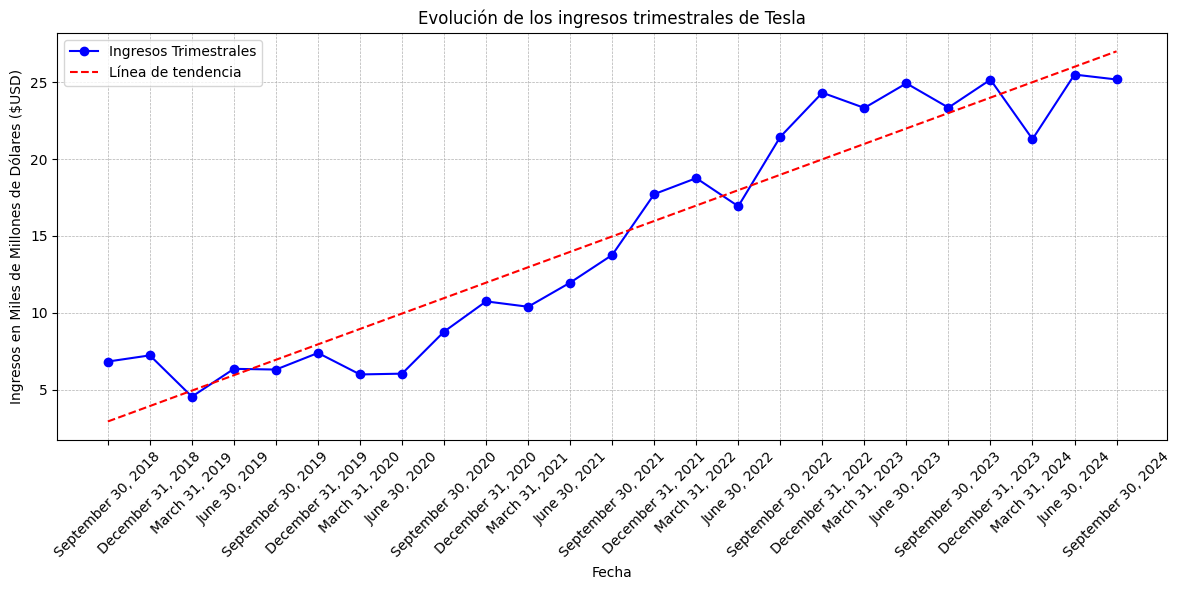

In [245]:


# Asegurarnos de que los valores en 'Ingresos' están en formato numérico
df['Ingresos'] = df['Ingresos'].replace({',': ''}, regex=True).astype(float)  # Eliminar comas y convertir a float
df['Ingresos'] = df['Ingresos'] / 1e9  # Convertimos los ingresos a miles de millones

# Revertimos el orden del DataFrame para que las fechas más antiguas estén al inicio
df = df[::-1].reset_index(drop=True)

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Ingresos'], marker='o', color='b', label='Ingresos Trimestrales')
plt.title("Evolución de los ingresos trimestrales de Tesla")
plt.xlabel("Fecha")
plt.ylabel("Ingresos en Miles de Millones de Dólares ($USD)")

# Rotar etiquetas del eje X para mayor legibilidad
plt.xticks(rotation=45)

# Mejorar los valores en el eje Y para que no estén en notación científica
plt.ticklabel_format(style='plain', axis='y')

# Añadir una cuadrícula para facilitar la lectura de valores
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Opcional: mostrar la línea de tendencia
z = np.polyfit(range(len(df['Ingresos'])), df['Ingresos'], 1)
p = np.poly1d(z)
plt.plot(df['Fecha'], p(range(len(df['Ingresos']))), "r--", label='Línea de tendencia')

plt.legend()
plt.tight_layout()
plt.show()

#### Gráfico 2: **Comparación de Ingresos Trimestrales por Año**

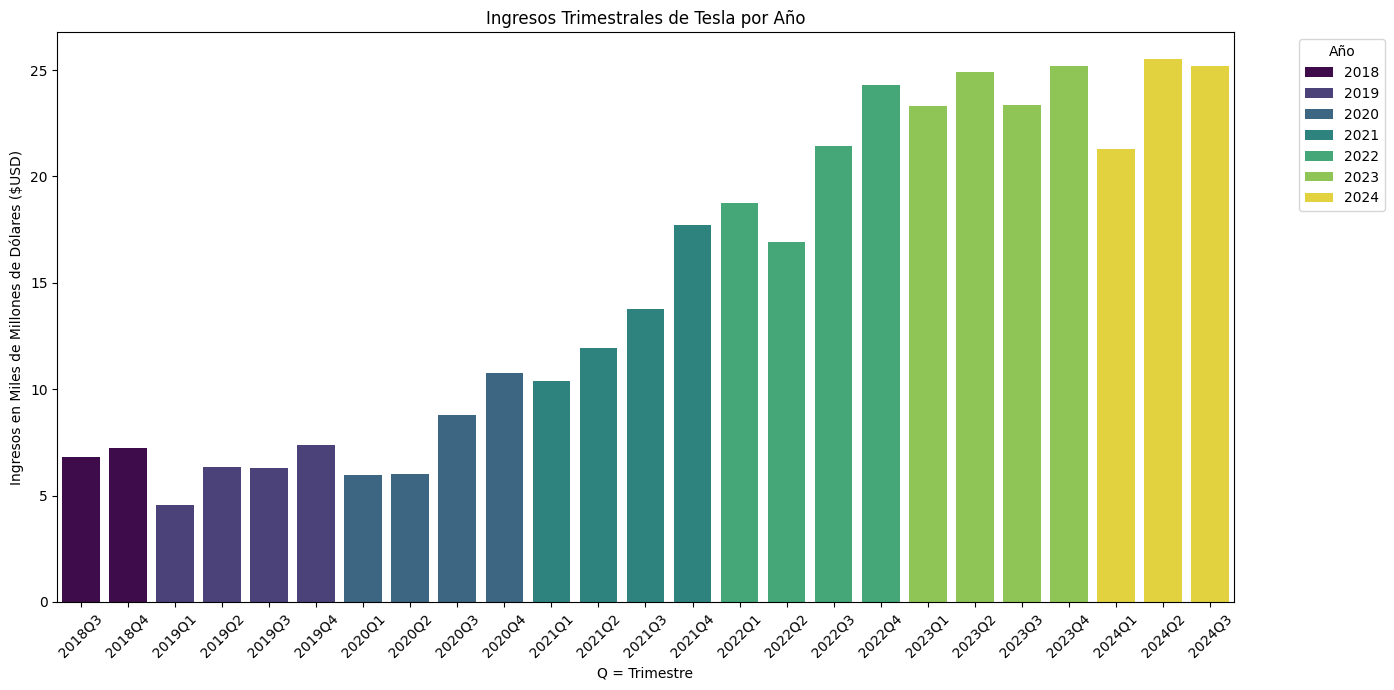

In [246]:
import seaborn as sns


# Extraemos el año y el trimestre de la columna de fecha
df['Año'] = pd.to_datetime(df['Fecha']).dt.year
df['Trimestre'] = pd.to_datetime(df['Fecha']).dt.to_period('Q').astype(str)



plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='Trimestre', y='Ingresos', hue='Año', palette='viridis')
plt.title("Ingresos Trimestrales de Tesla por Año")
plt.xlabel("Q = Trimestre")
plt.ylabel("Ingresos en Miles de Millones de Dólares ($USD)")
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### Gráfico 3: **Área acumulativa de ingresos**

<Figure size 1400x700 with 0 Axes>

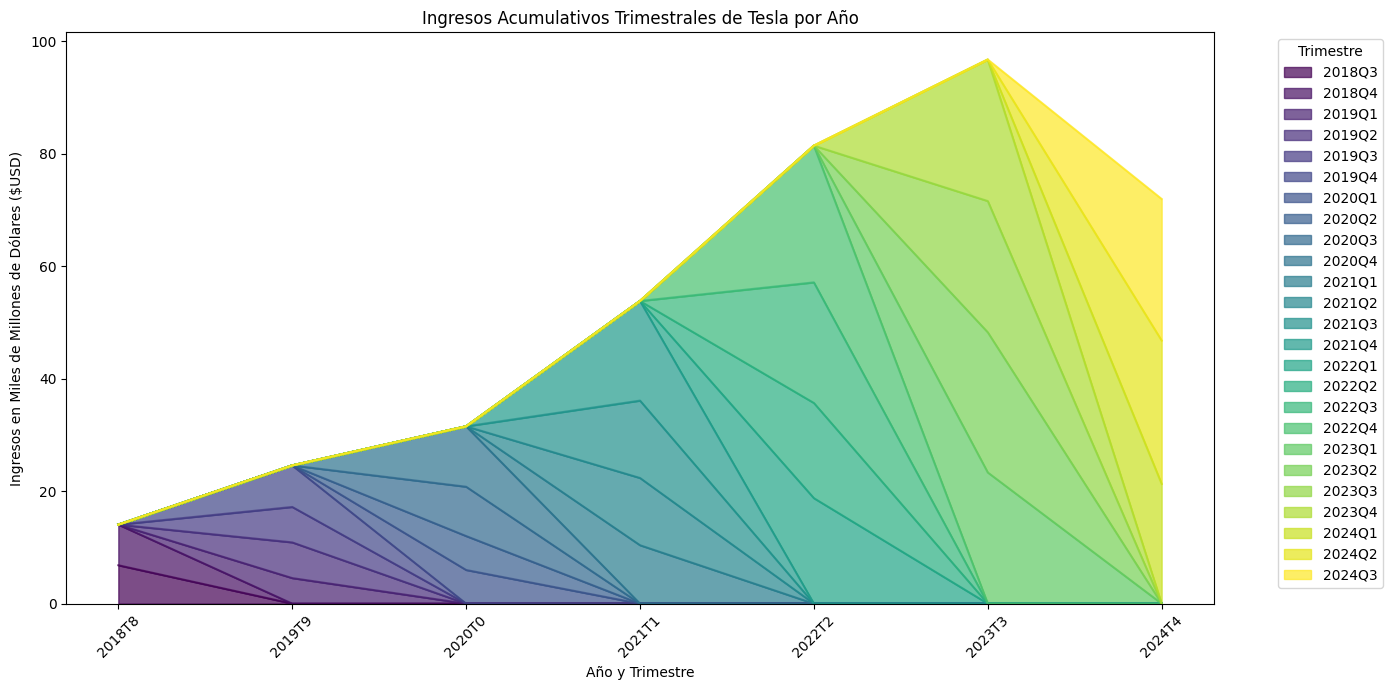

In [247]:
# Preparar datos
df['Año-Trimestre'] = df['Año'].astype(str) + "T" + df['Fecha'].str[-1]  # Crear columna para el eje X en formato 'AñoTn'
df = df.sort_values(by=['Año', 'Trimestre'])

plt.figure(figsize=(14, 7))
df_pivot = df.pivot_table(index='Año-Trimestre', columns='Trimestre', values='Ingresos', fill_value=0)
df_pivot.plot(kind='area', stacked=True, alpha=0.7, colormap="viridis", figsize=(14, 7))
plt.title("Ingresos Acumulativos Trimestrales de Tesla por Año")
plt.xlabel("Año y Trimestre")
plt.ylabel("Ingresos en Miles de Millones de Dólares ($USD)")
plt.legend(title='Trimestre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
